In [1]:
%reload_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
(128, 256) (128, 256) (128, 256)


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


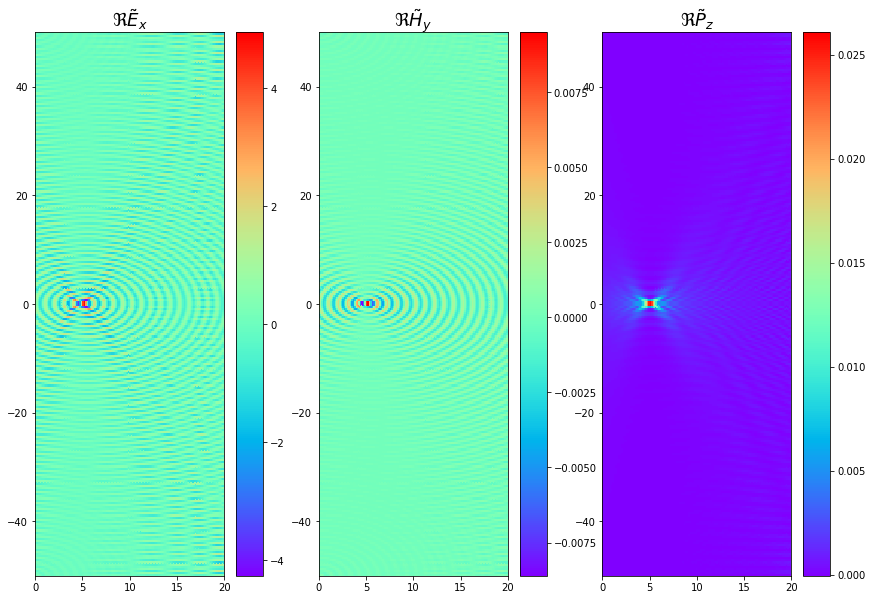

In [5]:
%pylab inline

import numpy as np
from scipy import constants
import scipy as sp
from scipy.special import hankel2
from matplotlib import pyplot as plt
from Electromagnetics.PWE import *


f = 100.0*constants.giga
L0 = constants.c/f
Ny = 2**8
Nz = 2**7
a = 50
b = 20
y = np.linspace(-a*L0, a*L0, Ny)
z = np.linspace(0, b*L0, Nz)
k0 = 2.0*np.pi/L0
theta = 0.0/180*np.pi
ky = k0*np.sin(theta)

figsize(10*b/a*3.6, 10)

def getEx(im_type="plane wave"):
    Ex = None
    if im_type=="plane wave":
        Ex = np.exp(1j*ky*y)   ## plane wave
    elif im_type=="gaussian beam":
        z_f =5.0*L0
        Ex = np.exp(-(y/(a*L0))**2)*np.exp(-1j*k0*np.sqrt(y**2 + z_f**2))   ## gaussian beam
    elif im_type=="2D dipole":
        z_f =5.0*L0
        Ex = hankel2(0, k0*np.sqrt(y**2 + z_f**2))   ## 2D dipole
    elif im_type=="backpropagated dipole":
        z0 = 5.0*L0
        Ex_z0 = (np.abs(y)<=0.2*L0)*np.ones(Ny, dtype=complex)
        Ey_z0 = np.zeros(Ny)
        pwe = PWE2D(f, y, np.zeros(Ny), np.zeros(Ny))
        pwe.GetK()
        Ex_0, Ey_0 = pwe.BackPropagateWithGain(Ex_z0, Ey_z0, z0)        
        Ex = Ex_0
    elif im_type=="circle":
        z_f = 10.0*L0
        r0 = 4.0*L0
        Ex = np.zeros(len(y), dtype=complex)
        n_p = 20
        for i in range(n_p):
            _z_ = r0*np.cos(i/n_p*2*np.pi)
            _y_ = r0*np.sin(i/n_p*2*np.pi)
            #Ex += hankel2(0, k0*np.sqrt((y-_y_)**2 + (z_f+_z_)**2))*np.exp(1j*np.random.rand(1)[0]*2*np.pi)   ## circle
            Ex += np.exp(-1j*k0*np.sqrt((y-_y_)**2 + (z_f+_z_)**2))*np.exp(1j*np.random.rand(1)[0]*2*np.pi)   ## circle
        Ex /= n_p
    elif im_type=="optimized circle":
        z_f = 10.0*L0
        r0 = 4.0*L0
        Z, Y = np.meshgrid(z, y, indexing='ij')
        mask = np.zeros((Nz, Ny), dtype=complex)
        mask = np.logical_and( (Y**2 + (Z-z_f)**2)>=(0.2*r0)**2, (Y**2 + (Z-z_f)**2)<=(1.1*r0)**2)
        plt.gca().pcolorfast(z/L0, y/L0, np.abs(mask.T), cmap='rainbow')
        plt.show()
                
        ey = np.zeros(Ny)
        def f_opt(ex_f_ri):
            nf = len(ex_f_ri)
            ex_f = np.array(ex_f_ri[0:int(nf/2)]) + 1j*np.array(ex_f_ri[int(nf/2):nf])
            _y = FourierReciprocalSpace(y)
            ex = InvFourier1D(y, _y, ex_f)
            pwe = PWE2D(f, y, ex, ey)
            pwe.GetK()
            Z, Y, E_zy, H_zy = pwe.GetFields(z)
            Ex_zy = E_zy[0]
            #Ex_zy = getEx(im_type="circle")
            #Ex_zy_f = Fourier1D(y, Ex_zy)[1]
            #print('Ex_zy_f : ', np.max(np.abs(np.real(Ex_zy_f))), np.max(np.abs(np.imag(Ex_zy_f))))
            #cost = np.sum(np.abs(np.abs(Ex_zy*mask) - np.abs(mask))) + np.sum(np.abs(np.abs(Ex_zy*np.logical_not(mask)) - np.abs(mask)))
            cost = np.sum(np.abs(np.abs(Ex_zy) - np.abs(mask)))
            return cost

        from Electromagnetics.Misc import tic, toc
        tic()
        from Electromagnetics.EvolAlgs import geneticAlg

        res = geneticAlg(f_opt, intervals=[(-0.1,0.1)]*2*Ny, n_bits=[8]*2*Ny, pop_size=1, n_gen=1,
                         pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False, parallel=True)
        print("optimum cost: ", res[1])
        
        ex_f_ri = res[0]
        ex_f = np.array(ex_f_ri[0:Ny]) + 1j*np.array(ex_f_ri[Ny:2*Ny])
        _y = FourierReciprocalSpace(y)
        ex = InvFourier1D(y, _y, ex_f)
        
        print("Processing time:", toc())
        
        Ex = ex
    else:
        raise ValueError()
    return Ex

Ex = getEx("gaussian beam")
Ey = np.zeros(Ny)


pwe = PWE2D(f, y, Ex, Ey)
pwe.GetK()

#z = np.linspace(4.0*L0, 6.0*L0, Nz)
Z, Y, E_zy, H_zy = pwe.GetFields(z)

print(Z.shape, Y.shape, E_zy[0].shape)



subplot(1, 3, 1)
pcolormesh(Z/L0, Y/L0, np.real(E_zy[0]), cmap='rainbow')
title(r'$\Re\tilde{E}_{x}$', fontsize=18)
colorbar() 

subplot(1, 3, 2)
pcolormesh(Z/L0, Y/L0, np.real(H_zy[1]), cmap='rainbow')
title(r'$\Re\tilde{H}_{y}$', fontsize=18)
colorbar() 

subplot(1, 3, 3)
P_zy = 0.5*np.cross(np.array(E_zy), np.conjugate(np.array(H_zy)), axis=0)
pcolormesh(Z/L0, Y/L0, np.real(P_zy[2]), cmap='rainbow')
title(r'$\Re\tilde{P}_{z}$', fontsize=18)
colorbar() 
show()




### 3D Gaussian beam

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


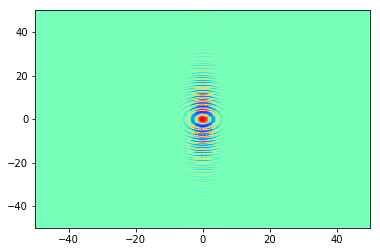

In [51]:
%pylab inline

import numpy as np
from scipy import constants
import scipy as sp
from scipy.special import hankel2
from matplotlib import pyplot as plt
from Electromagnetics.PWE import *


f = 100.0*constants.giga
L0 = constants.c/f
Nx = 2**8
Ny = 2**8
Nz = 2**7
a = 50
b = 20
x = np.linspace(-a*L0, a*L0, Nx)
y = np.linspace(-a*L0, a*L0, Ny)
z = np.linspace(0, b*L0, Nz)
k0 = 2.0*np.pi/L0

z_f = 10*L0 #focus

X, Y = np.meshgrid(x, y, indexing='ij')
#Ex0 = np.exp(-(X**2 + Y**2)/(2*L0)**2)*np.exp(-1j*k0*np.sqrt(X**2 + Y**2 + z_f**2))
Ex0 = np.exp(-(X**2/(4*L0)**2 + Y**2/(20*L0)**2))*np.exp(-1j*k0*np.sqrt(X**2 + Y**2 + z_f**2))
#Ex0 = np.genfromtxt('other/Ex0.csv', delimiter=',', dtype=complex)
pcolormesh(X/L0, Y/L0, np.real(Ex0), cmap="rainbow")

Ey0 = 0*Ex0

pwe = PWE3D(f, X, Y, Ex0, Ey0)
pwe.GetK()

[X_3D, Y_3D, Z_3D], [Ex_xyz, Ey_xyz, Ez_xyz], [Hx_xyz, Hy_xyz, Hz_xyz] = pwe.GetFields(z)


infinity:  False
nan:  False
Max:  10.0159649511
ind_z =  0


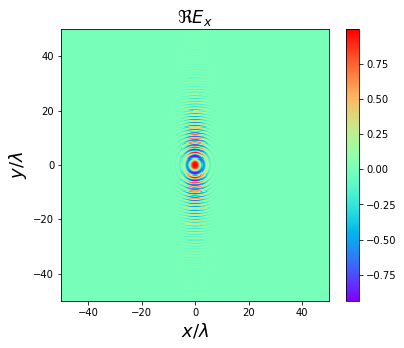

ind_x =  127


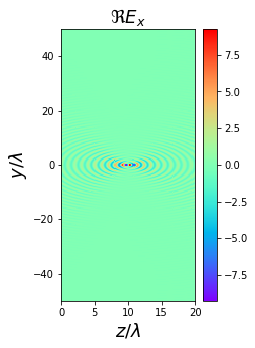

ind_y =  127


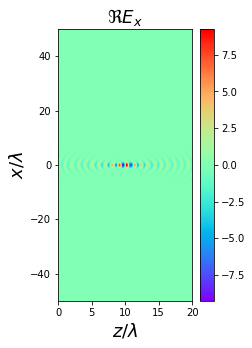

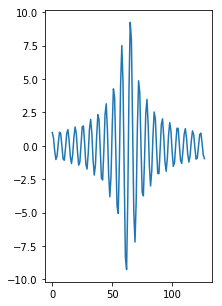

In [52]:
print("infinity: ", np.any(np.isinf(Ex_xyz)))
print("nan: ", np.any(np.isnan(Ex_xyz)))
print("Max: ", np.max(np.abs(Ex_xyz)))

figsize(5+1, 5)

_z_ = 0.0*L0
ind_z = np.argmin(np.abs(z-_z_))
print("ind_z = ", ind_z)
pcolormesh(X_3D[:,:,ind_z]/L0, Y_3D[:,:,ind_z]/L0, np.real(Ex_xyz[:,:,ind_z]), cmap="rainbow")
colorbar()
xlabel(r'$x/\lambda$', fontsize=18)
ylabel(r'$y/\lambda$', fontsize=18)
title(r'$\Re{E_x}$', fontsize=18)
show()

figsize(5*b/a+1, 5)

_x_ = 0.0*L0
ind_x = np.argmin(np.abs(x-_x_))
print("ind_x = ", ind_x)
pcolormesh(Z_3D[ind_x, :,:].T/L0, Y_3D[ind_x, :,:].T/L0, np.real(Ex_xyz[ind_x, :,:].T), cmap="rainbow")
colorbar()
xlabel(r'$z/\lambda$', fontsize=18)
ylabel(r'$y/\lambda$', fontsize=18)
title(r'$\Re{E_x}$', fontsize=18)
show()

_y_ = 0.0*L0
ind_y = np.argmin(np.abs(y-_y_))
print("ind_y = ", ind_y)
pcolormesh(Z_3D[:, ind_y, :].T/L0, X_3D[:, ind_y, :].T/L0, np.real(Ex_xyz[:, ind_y, :].T), cmap="rainbow")
colorbar()
xlabel(r'$z/\lambda$', fontsize=18)
ylabel(r'$x/\lambda$', fontsize=18)
title(r'$\Re{E_x}$', fontsize=18)
show()

plot(np.real(Ex_xyz[ind_x, ind_y, :]))
show()
